# ⏱ Synchronize data streams ⏱

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/02_Synchronize_data_streams.ipynb)

In Colab install wax by executing this line in a cell:
```python
! pip install "wax-ml[dev,complete] @ git+https://github.com/eserie/wax-ml.git"
```

Let's illustrate with a small example how `wax.stream.Stream` synchronizes data streams.

Let's use the dataset "air temperature" with :
- An air temperature defined with hourly resolution.
- A "fake" ground temperature defined with a daily resolution as the air temperature minus 10 degrees.

In [1]:
import xarray as xr

da = xr.tutorial.open_dataset("air_temperature")
da["ground"] = da.air.resample(time="d").last().rename({"time": "day"}) - 10

Let's see what this dataset looks like:

In [2]:
da

<xarray.Dataset>
Dimensions:  (day: 730, lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * day      (day) datetime64[ns] 2013-01-01 2013-01-02 ... 2014-12-31
Data variables:
    air      (time, lat, lon) float32 ...
    ground   (day, lat, lon) float32 231.9 231.8 231.8 ... 286.5 286.2 285.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
from wax.accessors import register_wax_accessors

register_wax_accessors()

In [4]:
from wax.modules import EWMA


def my_custom_function(da):
    return {
        "air_10": EWMA(1.0 / 10.0)(da["air"]),
        "air_100": EWMA(1.0 / 100.0)(da["air"]),
        "ground_100": EWMA(1.0 / 100.0)(da["ground"]),
    }

In [5]:
results, state = da.wax.stream(local_time="time", pbar=True).apply(
    my_custom_function, format_dims=da.air.dims
)

time:   0%|          | 0/2920 [00:00<?, ?it/s]

stream_unroll: 0it [00:00, ?it/s]

day:   0%|          | 0/730 [00:00<?, ?it/s]

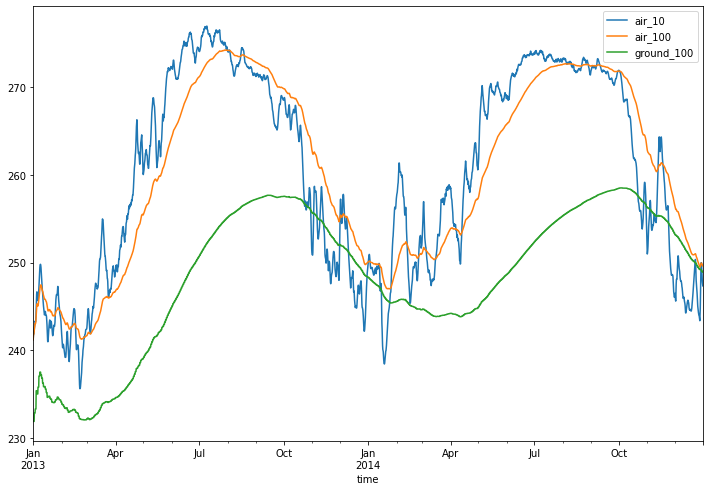

In [6]:
_ = results.isel(lat=0, lon=0).drop(["lat", "lon"]).to_pandas().plot(figsize=(12, 8))